# Reaction Network: Demo Notebook
### Author: Matthew McDermott
### Date: May 20, 2020

The following notebook serves as a walkthrough for the use of the *reaction-network* code, which is imported as *rxn_network*. 

We consider the Y-Mn-O-Li-Cl-C chemical system as referenced in the original paper.

## Imports
The following imports are required to access the Materials Project database and construct the network.  Don't worry if you see an error regarding the cairo package for drawing; we will not be using it.

In [1]:
import logging

from rxn_network.core import ReactionNetwork
from rxn_network.helpers import GibbsComputedStructureEntry
from rxn_network.analysis import PathwayAnalysis

from pymatgen import MPRester, Structure
from pymatgen.entries.computed_entries import ComputedStructureEntry
from pymatgen.analysis.phase_diagram import PhaseDiagram, PDPlotter, PDEntry
from pymatgen.analysis.reaction_calculator import Reaction
from pymatgen import Composition

logging.info("Logging initialized")

## Building the phase diagram entries

In [2]:
with MPRester() as mpr:  # requires API key from Materials Project
    all_entries = mpr.get_entries_in_chemsys(["Y","Mn","O","Li","Cl","C"], inc_structure="final")

In [3]:
temp = 900  # designate a temperature for estimating high-temperature phase diagram

pd_mp = PhaseDiagram(all_entries)

gibbs_entries = GibbsComputedStructureEntry.from_pd(pd_mp,temp)
pd_gibbs = PhaseDiagram(gibbs_entries)

print(pd_mp)
print(pd_gibbs)

Li-Y-Mn-C-Cl-O phase diagram
47 stable phases: 
Li, LiO8, YCl3, MnCO3, Y2Cl3, Y(ClO4)3, MnCl2, YMnO3, Y2O3, YCCl, Li2MnO3, Li4Mn5O12, Li2CO3, Mn2O3, LiYO2, Y2Mn2O7, Cl2O, Y10Mn13C18, Y3C4, LiCl, LiMnO2, Y4C5, Mn23C6, Mn, Y, Li2O, Y4C7, C, ClO3, Cl2O7, CO2, Y2C, LiClO4, MnO, Cl2, Mn8Cl3O10, ClO2, O2, Mn3O4, Li6MnO4, LiC12, CCl4, YMn2O5, YClO, MnO2, Li2O2, Li5Mn7O16
Li-Y-Mn-C-Cl-O phase diagram
39 stable phases: 
YCCl, Li5Mn7O16, Y10Mn13C18, YMnO3, Y2C, Y4C5, LiCl, Mn2O3, Li2MnO3, Y4C7, Li3MnO3, Li6MnO4, C, MnO, YMn2O5, Y2O3, YClO, MnO2, Mn8Cl3O10, O2, Mn, LiYO2, CCl2O, MnCO3, Li2O, LiC12, LiMnO2, Y, YCl3, CCl3, Li2CO3, YMn12, Y2MnC4, MnCl2, Y2Mn2O7, Li, Mn3O4, CO2, Cl2


## Creating the reaction network

We simply initialize the reaction network object by providing the entry objects, maximum number of phases, and some other specified parameters.

In [4]:
rn = ReactionNetwork(gibbs_entries, 2, include_metastable=0.020) 

INFO:ReactionNetwork:Initializing network with 56 entries: 
Li, C, O2, LiC12, Li2O, CO2, Li7Mn17O32, Li9Mn7O16, Cl2, Li2CO3, Li9Mn15O32, LiCl, Li9Mn20O40, Li9Mn21O40, CCl3, Li13Mn17O40, ClO, Mn, CCl2O, MnO, MnO2, Mn2O3, Mn3O4, LiMnO2, LiMn2O4, MnCO3, Y, Li2MnO3, MnCl2, Li2Mn(CO3)2, Li3MnO3, Y2C, Y3C4, Y2O3, Y4C5, Y4C7, Mn8Cl3O10, LiYO2, Li3Mn2O5, Li4Mn3O7, YCl3, Li4Mn5O12, Li5MnO4, Li5Mn7O16, Li5Mn12O24, Li6MnO4, YCCl, Li7Mn5O12, YClO, YMn12, Y2MnC4, Y10Mn13C18, YMnO3, YMn2O5, Y2Mn2O7, Li95Mn16O64


Now, we designate 

In [5]:
reactants = ["Mn2O3", "YCl3","Li2CO3"]
products = ["YMnO3","CO2","LiCl"]

reactants = [Composition(r) for r in reactants]
products = [Composition(p) for p in products]

net_rxn = Reaction(reactants,products)
print(f"Net RXN: {net_rxn}")

Net RXN: 0.5 Mn2O3 + YCl3 + 1.5 Li2CO3 -> YMnO3 + 1.5 CO2 + 3 LiCl


We then need to select which entries correspond to the reactants and products. If we only know the compositions we want, we need to iterate through all of the entires to find them:

In [6]:
reactant_entries = []
product_entries = []

for entry in rn._filtered_entries:
    if entry.composition.reduced_composition in reactants:
        reactant_entries.append(entry)
    elif entry.composition.reduced_composition in products:
        product_entries.append(entry)

Finally, we generate the reaction network. This process iterates through all possible chemical reactions and creates weighted edges using the designated cost function. 

**Note**: this particular graph will likely take 2+ minutes to generate, depending on your CPU specs.

In [7]:
rn.generate_rxn_network(reactant_entries,product_entries,"softplus",temp=900)

INFO:ReactionNetwork:Generating reactions...
INFO:ReactionNetwork:Created graph with 3194 nodes and 33428 edges.


## Finding shortest pathways

Reaction pathways are identified by finding the k shortest paths to each target, and then attempting to combine identified reactions to form a set that satisifies the stoichiometry of the net reaction. 

**Note:** the k-shortest paths algorithm (Yen's algorithm) typically performs very quickly, but the postprocessing of combinations can take >1 minute.

In [15]:
k=10
paths, analysis = rn.find_all_rxn_pathways(k, max_num_combos=4, rxns_only=True)

NET RXN: YCl3 + 0.5 Mn2O3 + 1.5 Li2CO3 -> YMnO3 + 3 LiCl + 1.5 CO2 

PATHS to CO2 

PATHS to YMnO3 

PATHS to LiCl 

Remnant Reactions 

{YClO + LiMnO2 -> YMnO3 + LiCl (dG = -0.086 eV/atom) 
Total Cost: 0.404} 



In [16]:
for num,path in enumerate(paths):
    print(f"Path {num+1}:","\n")
    print(path)
    print("\n")

Path 1: 

0.5 Mn2O3 + 1.5 Li2CO3 -> Li3MnO3 + 1.5 CO2 (dG = 0.199 eV/atom) 
YCl3 + Li3MnO3 -> YMnO3 + 3 LiCl (dG = -0.225 eV/atom) 

Average Cost: 0.266 
Total Cost: 0.532


Path 2: 

0.5 Mn2O3 + 0.5 Li2CO3 -> LiMnO2 + 0.5 CO2 (dG = 0.099 eV/atom) 
Li2CO3 -> Li2O + CO2 (dG = 0.312 eV/atom) 
YCl3 + Li2O -> YClO + 2 LiCl (dG = -0.287 eV/atom) 
YClO + LiMnO2 -> YMnO3 + LiCl (dG = -0.086 eV/atom) 

Average Cost: 0.311 
Total Cost: 1.245




In [131]:
analysis.balanced_combined_paths

{0.5 Mn2O3 + 0.5 Li2CO3 -> LiMnO2 + 0.5 CO2 (dG = 0.099 eV/atom) 
 Li2CO3 -> Li2O + CO2 (dG = 0.312 eV/atom) 
 YCl3 + Li2O -> YClO + 2 LiCl (dG = -0.287 eV/atom) 
 YClO + LiMnO2 -> YMnO3 + LiCl (dG = -0.086 eV/atom) 
 
 Average Cost: 0.311 
 Total Cost: 1.245,
 0.5 Mn2O3 + 1.5 Li2CO3 -> Li3MnO3 + 1.5 CO2 (dG = 0.199 eV/atom) 
 YCl3 + Li3MnO3 -> YMnO3 + 3 LiCl (dG = -0.225 eV/atom) 
 
 Average Cost: 0.266 
 Total Cost: 0.532}

The "analysis" object also contains some helpful methods for analyzing suggested pathways, such as plotting of the frequency of intermediates which occur.

<BarContainer object of 4 artists>

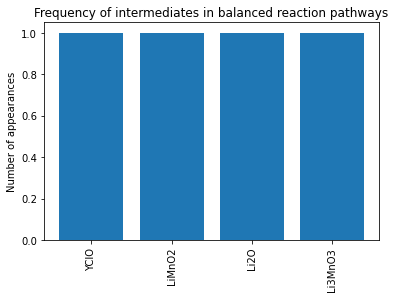

In [18]:
analysis.plot_intermediate_freq()

## Plotting the network

In [11]:
import pyintergraph
import networkx as nx

nx_graph = pyintergraph.gt2nx(rn.g)

mapping = {}
for node in nx_graph.nodes(data=True):
    mapping[node[0]] = node[1]["entries"]
    
nx.relabel_nodes(nx_graph, mapping,copy=False)

In [17]:
import graphistry
graphistry.register(key='API_key')
graphistry.bind(source='src', destination='dst', node='nodeid', point_color='type',point_size='path').plot(nx_graph)

NameError: name 'nx_graph' is not defined

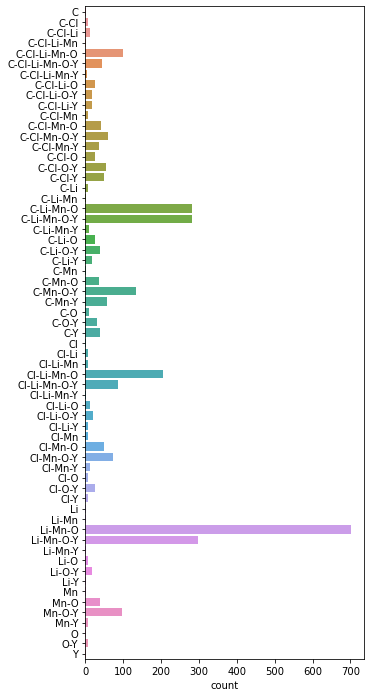

In [41]:
import seaborn as sns
plt.figure(figsize=(5,12))
sns.countplot(y=sorted(list(rn.g.vp["chemsys"])),orient="v")

In [42]:
import graph_tool.all as gt

In [110]:
rn.g.ep["zero_cost"] = rn.g.new_edge_property("bool")
for s,t,weight in rn.g.iter_edges(eprops=[rn.g.ep["weight"]]):
    rn.g.ep["zero_cost"][rn.g.edge(s,t)] = (weight!=0)

In [112]:
filtered_graph = gt.GraphView(rn.g, efilt=rn.g.ep.zero_cost)

In [113]:
filtered_graph

<GraphView object, directed, with 3194 vertices and 20116 edges, 5 internal vertex properties, 5 internal edge properties, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x1507edbb0, at 0x150a22e50>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x1507edbb0, at 0x150a22a90>, False), at 0x1507edbb0>

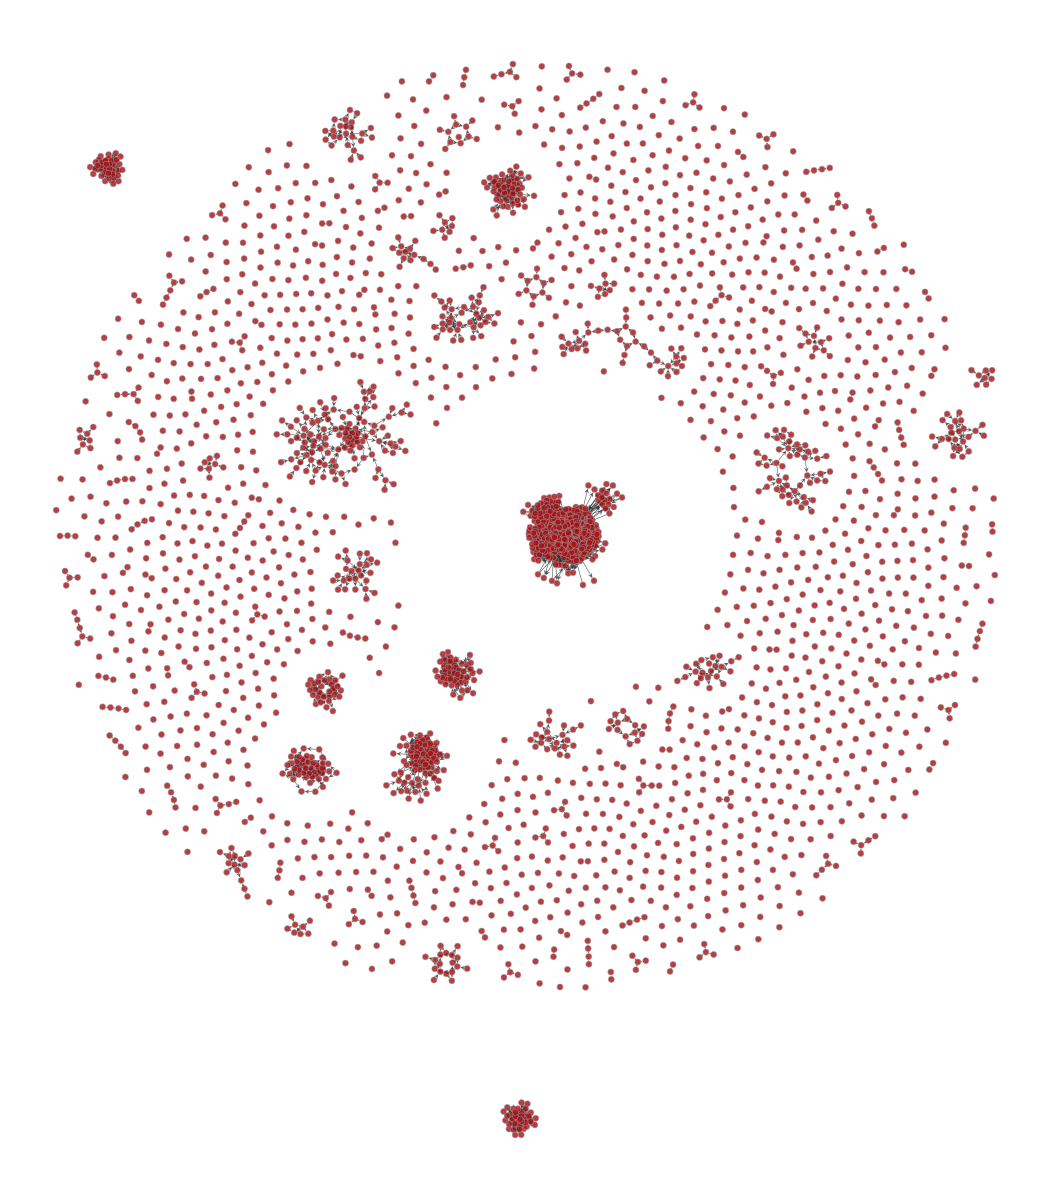

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x1507edbb0, at 0x1508d9df0>

In [114]:
gt.graph_draw(filtered_graph)